# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID:  7   
TEAM-NAME: the-jokers       
YOUR-ID:      
YOUR-NAME:    

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP. You have to add these answers to the tasks after your code in a section already titled `Section_number Answer` for example, `2.1 Answer`.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax
import jax.numpy as jnp 
from jax import jacfwd

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [2]:
##############################################################################
# TODO: Code for Section 1                
##############################################################################
# TODO: Code for Section 1                                                   #
u_noisy = jnp.array([1.1, 1.0, 1.1, -2.7, 0.0]);
u_gt = jnp.array([1.0, 1.0, 1.0, -3.0, 0.0]);
x_noisy = 0;
x_gt = 0;

def frobNorm(P1, P2, str1, str2):
    jnp.set_printoptions(suppress=True);
    val = jnp.linalg.norm(P1 - P2, 'fro');
    print(f"Frobenius norm between {str1} and {str2} is: {val}\n");

def traj(x,u):
    L = len(u)-1;
    X = [];
    X.append(x);
    Sum = 0;
    for k in range(L):
        Sum = Sum + u[k];
        X.append(x+Sum);
    X = jnp.array(X);
    return X;

def residual(x,u):
    f = [];
    L = len(x)-1;
    for i in range(L):
        f.append((x[i]+u[i])-x[i+1])
    f.append(x[0]+ u[4] - x[4]) 
    f.append(x[0])
    f = jnp.array(f)
    return f;

def Jacobian(x,u):
    f = lambda x: residual(x,u); 
    J = jacfwd(f);
    return J(x);

odo = 100; loop = 5000; anchor = 10000;

S = jnp.array([
    [odo, 0, 0, 0, 0, 0],
    [0, odo, 0, 0, 0, 0],
    [0, 0, odo, 0, 0, 0],
    [0, 0, 0, odo, 0, 0],
    [0, 0, 0, 0, loop, 0],
    [0, 0, 0, 0, 0, anchor]
]);

J = jnp.array([
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [0, 0, 0, 1, -1],
    [1, 0, 0, 0, -1],
    [1, 0, 0, 0, 0]
]);

def GN(J,S,x,u,N,tol):
    J_u = J.T@S@J;
    for i in range(N):
        f = residual(x,u);
        J_jax = Jacobian(x,u);
        print(frobNorm(J, J_jax,"analytical", "jax Jacobian"));
        update = jnp.linalg.inv(J_u)@J.T@S.T@f;
        print("The poses in ",i,"th iteration are ",x,"\n");
        x = x - update
        if(jnp.linalg.norm(update)<tol):
            print("algo converged in the ",i,"th iteration with poses ",x,"\n");
            break;
    return x;

X_gt = traj(x_gt,u_gt);
X_noisy = traj(x_noisy,u_noisy);
X_optimised = GN(J,S,X_noisy,u_noisy,10,1e-5);
print("The Ground truth poses are",X_gt);
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

/home/karan/anaconda3/envs/mr_assignment1/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Frobenius norm between analytical and jax Jacobian is: 0.0

None
The poses in  0 th iteration are  [0.         1.1        2.1        3.1999998  0.49999976] 

Frobenius norm between analytical and jax Jacobian is: 0.0

None
The poses in  1 th iteration are  [0.         0.975622   1.8512439  2.8268657  0.00248754] 

algo converged in the  1 th iteration with poses  [-0.          0.97562194  1.8512437   2.8268657   0.00248756] 

The Ground truth poses are [0. 1. 2. 3. 0.]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

    1. Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.
    
    2. [[CP-M]] What did you get as the dimension of Jacobian, information matrix and residual? Please add dimensions of Jacobian, Residual, information matrix as part of your descriptive answer 2.1 below (after the code).

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

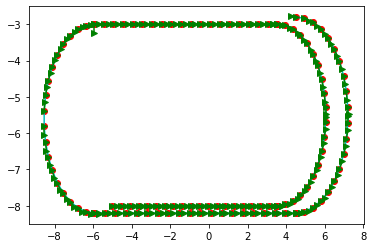

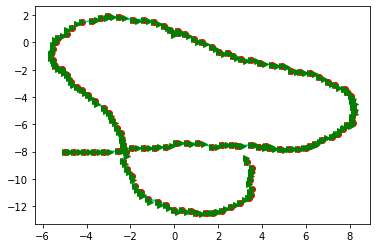

In [3]:
##############################################################################
# TODO: Code for Section 2.1                                                 
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta)) 

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

# Plotting trajectory using matplotlib
def draw(X, Y, THETA,N):
    ax = plt.subplot(111)
    ax.plot(X[:N], Y[:N], 'ro')
    plt.plot(X[:N], Y[:N], 'c-')
    for i in range(N):
        x2 = 0.25*jnp.cos(THETA[i]) + X[i]
        y2 = 0.25*jnp.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
    plt.show()
    
# Plotting trajectory using matplotlib
def draw_all(X_gt, Y_gt, THETA_gt,X_noisy, Y_noisy, THETA_noisy,X,Y,THETA,N):
    ax = plt.subplot(111)
    ax.plot(X_gt[:N], Y_gt[:N], 'ro')
    ax.plot(X_noisy[:N], Y_noisy[:N], 'bo')
    ax.plot(X[:N], Y[:N], 'go')
    plt.plot(X_gt[:N], Y_gt[:N], 'c-')
    plt.plot(X_noisy[:N], Y_noisy[:N], 'c-')
    plt.plot(X[:N], Y[:N], 'c-')
    for i in range(N):
        x_gt = 0.25*jnp.cos(THETA_gt[i]) + X_gt[i]
        y_gt = 0.25*jnp.sin(THETA_gt[i]) + Y_gt[i]
        plt.plot([X_gt[i], x_gt], [Y_gt[i], y_gt], 'g->')
        
        x_noisy = 0.25*jnp.cos(THETA_noisy[i]) + X_noisy[i]
        y_noisy = 0.25*jnp.sin(THETA_noisy[i]) + Y_noisy[i]
        plt.plot([X_noisy[i], x_noisy], [Y_noisy[i], y_noisy], 'r->')
        
        x = 0.25*jnp.cos(THETA[i]) + X[i]
        y = 0.25*jnp.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x], [Y[i], y], 'b->')
    plt.show()
    
#Initial Trajectory
def init_traj(i,j,x,y,theta,dx,dy,dtheta):
    L = len(j)+1;
    X = jnp.empty((L,1));
    Y = jnp.empty((L,1));
    Theta = jnp.empty((L,1));
    X = jax.ops.index_update(X,jax.ops.index[0],x);
    Y = jax.ops.index_update(Y,jax.ops.index[0],y);
    Theta = jax.ops.index_update(Theta,jax.ops.index[0],theta);
    for k in range(L-1):
        val_x = X[i[k]]+dx[k]*jnp.cos(Theta[i[k]])-dy[k]*jnp.sin(Theta[i[k]]);
        val_y = Y[i[k]]+dx[k]*jnp.sin(Theta[i[k]])+dy[k]*jnp.cos(Theta[i[k]]);
        val_Theta = Theta[i[k]] + dtheta[k];
        X = jax.ops.index_update(X,jax.ops.index[k+1],val_x);
        Y = jax.ops.index_update(Y,jax.ops.index[k+1],val_y);
        Theta = jax.ops.index_update(Theta,jax.ops.index[k+1],val_Theta);
    return(X,Y,Theta)

x_gt,y_gt,theta_gt = readVertex("./dataset/gt.txt");
i_gt,j_gt,dx_gt,dy_gt,dtheta_gt = readEdge("./dataset/gt.txt");
N = max(j_gt)+1;
draw(x_gt,y_gt,theta_gt,N);


x_noisy,y_noisy,theta_noisy = readVertex("./dataset/edges.txt");
i_noisy,j_noisy,dx_noisy,dy_noisy,dtheta_noisy = readEdge("./dataset/edges.txt");
X_noisy,Y_noisy,Theta_noisy = init_traj(i_noisy,j_noisy,x_noisy,y_noisy,theta_noisy,dx_noisy,dy_noisy,dtheta_noisy);
draw(X_noisy,Y_noisy,Theta_noisy,N);

with open('./dataset/edges-poses.g2o', 'w') as filehandle:
    for k in range(N):
        filehandle.writelines("VERTEX_SE2 " )
        a = X_noisy[k].item(); 
        b = Y_noisy[k].item(); 
        c = Theta_noisy[k].item();
        filehandle.writelines(str(k)+" ");
        filehandle.writelines(str(a)+" ");
        filehandle.writelines(str(b)+" ");
        filehandle.writelines(str(c));
        filehandle.writelines("\n");
    filehandle.writelines([l for l in open("./dataset/edges.txt").readlines() if "EDGE_SE2" in l ])

#################################len(j)#############################################
#                             END OF YOUR CODE                               #
##############################################################################

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  0 ; cost =  228347.15625


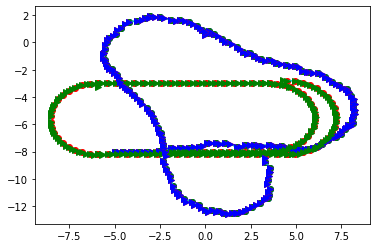

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  1 ; cost =  29562.77734375
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  2 ; cost =  545.8777465820312
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  3 ; cost =  250.66563415527344
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  4 ; cost =  250.66563415527344
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  5 ; cost =  110.4676513671875
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  6 ; cost =  110.4676513671875
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  7 ; cost =  61.1010627746582
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  8 ; cost =  61.1010627746582
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  9 ; cost =  55.24324417114258
Frobenius norm between analytical and ja

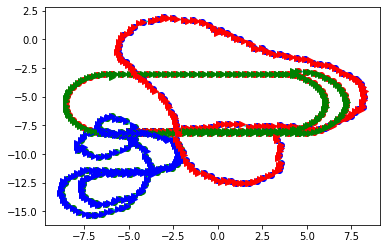

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  11 ; cost =  51.22709274291992
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  12 ; cost =  51.22709274291992
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  13 ; cost =  47.974647521972656
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  14 ; cost =  47.974647521972656
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  15 ; cost =  45.028907775878906
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  16 ; cost =  45.028907775878906
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  17 ; cost =  42.37358474731445
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  18 ; cost =  42.37358474731445
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  19 ; cost =  40.05708312988281
Frobenius norm between a

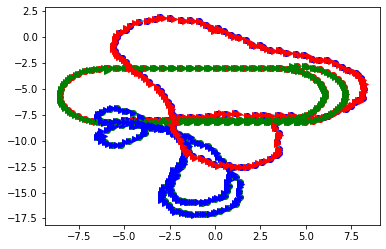

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  21 ; cost =  38.02452087402344
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  22 ; cost =  38.02452087402344
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  23 ; cost =  36.2650260925293
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  24 ; cost =  36.2650260925293
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  25 ; cost =  34.72977828979492
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  26 ; cost =  34.72977828979492
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  27 ; cost =  33.386051177978516
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  28 ; cost =  33.386051177978516
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  29 ; cost =  32.20231246948242
Frobenius norm between analy

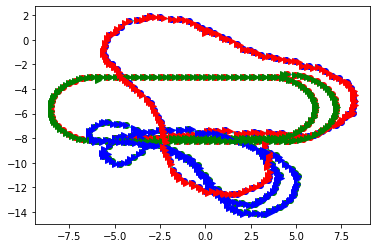

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  31 ; cost =  31.156370162963867
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  32 ; cost =  31.156370162963867
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  33 ; cost =  30.2304744720459
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  34 ; cost =  30.2304744720459
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  35 ; cost =  29.410903930664062
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  36 ; cost =  29.410903930664062
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  37 ; cost =  28.686227798461914
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  38 ; cost =  28.686227798461914
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  39 ; cost =  28.046674728393555
Frobenius norm between 

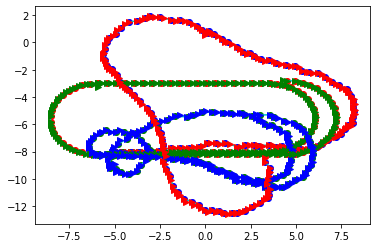

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  41 ; cost =  27.483543395996094
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  42 ; cost =  27.483543395996094
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  43 ; cost =  26.988906860351562
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  44 ; cost =  26.988906860351562
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  45 ; cost =  26.555633544921875
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  46 ; cost =  26.555633544921875
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  47 ; cost =  26.177101135253906
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  48 ; cost =  26.177101135253906
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  49 ; cost =  25.847259521484375
Frobenius norm betw

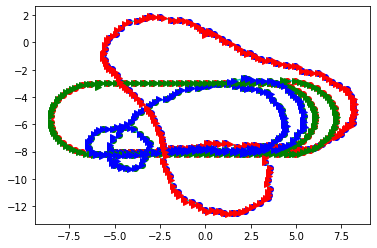

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  51 ; cost =  25.560565948486328
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  52 ; cost =  25.560565948486328
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  53 ; cost =  25.31193733215332
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  54 ; cost =  25.31193733215332
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  55 ; cost =  25.096811294555664
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  56 ; cost =  25.053245544433594
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  57 ; cost =  24.431886672973633
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  58 ; cost =  23.981182098388672
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  59 ; cost =  23.8668212890625
Frobenius norm between 

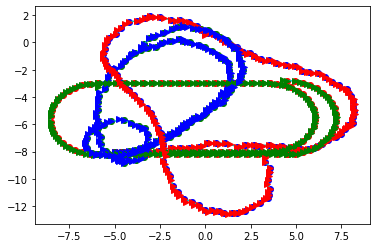

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  61 ; cost =  23.815067291259766
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  62 ; cost =  23.809574127197266
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  63 ; cost =  23.80730438232422
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  64 ; cost =  23.806337356567383
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  65 ; cost =  23.80592918395996
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  66 ; cost =  23.805757522583008
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  67 ; cost =  23.805673599243164
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  68 ; cost =  23.805652618408203
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  69 ; cost =  23.805635452270508
Frobenius norm betwee

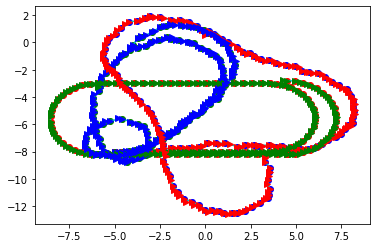

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  71 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  72 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  73 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  74 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  75 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  76 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  77 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  78 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  79 ; cost =  23.805635452270508
Frobenius norm betw

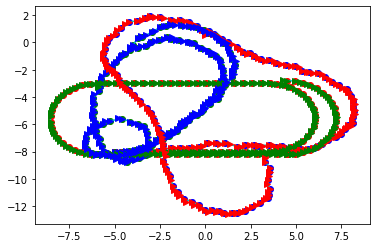

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  81 ; cost =  23.805635452270508
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  82 ; cost =  23.80562973022461
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  83 ; cost =  23.805627822875977
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  84 ; cost =  23.805627822875977
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  85 ; cost =  23.805627822875977
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  86 ; cost =  23.805625915527344
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  87 ; cost =  23.80562400817871
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  88 ; cost =  23.80562400817871
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  89 ; cost =  23.80562400817871
Frobenius norm between 

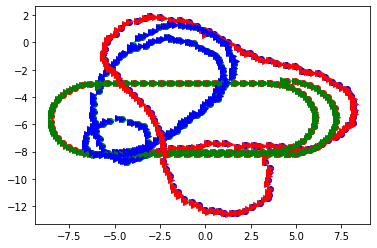

Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  91 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  92 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  93 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  94 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  95 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  96 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  97 ; cost =  23.805622100830078
Frobenius norm between analytical and jax Jacobian is: 0.0
None
iteration =  98 ; cost =  23.805622100830078


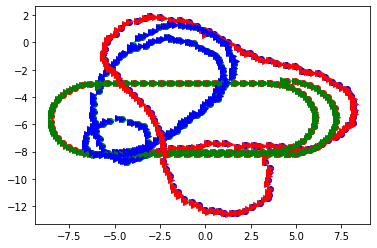

Final cost =  [[23.805622]]


In [4]:
def residual(i,j,dx,dy,dtheta,X,Y,Theta):
    res = [];
    L = len(j);
    for k in range(L):
        val_x = X[i[k]]+dx[k]*jnp.cos(Theta[i[k]])-dy[k]*jnp.sin(Theta[i[k]]);
        res.append(val_x - X[j[k]]);
        
    res.append(X[0] - (-5));
    
    for k in range(L):
        val_y = Y[i[k]]+dx[k]*jnp.sin(Theta[i[k]])+dy[k]*jnp.cos(Theta[i[k]]);
        res.append(val_y - Y[j[k]]);
    
    res.append(Y[0] - (-8));
    
    for k in range(L):
        val_Theta = Theta[i[k]] + dtheta[k];
        res.append(val_Theta - Theta[j[k]]);
    
    res.append(Theta[0] - 0);
    
    res = jnp.array(res).reshape(-1,1);
    
    return res

def Jacobian(i,j,dx,dy,Theta):
    L = len(j);
    M = max(j);
    q_th = 2*M+2;
    J = jnp.zeros((3*(L+1),3*(M+1)));
    for k in range(0,L):
        diff_theta = -dx[k]*jnp.sin(Theta[i[k]])-dy[k]*jnp.cos(Theta[i[k]]);
        J = jax.ops.index_update(J,jax.ops.index[k,i[k]],1);
        J = jax.ops.index_update(J,jax.ops.index[k,j[k]],-1);
        J = jax.ops.index_update(J,jax.ops.index[k,i[k]+q_th],diff_theta.item());
    J = jax.ops.index_update(J,jax.ops.index[L,0],1);
    p = L+1;
    q = M+1;
    for k in range(L+1,2*L+1):
        diff_theta = dx[k-p]*jnp.cos(Theta[i[k-p]])-dy[k-p]*jnp.sin(Theta[i[k-p]]);
        J = jax.ops.index_update(J,jax.ops.index[k,i[k-p]+q],1);
        J = jax.ops.index_update(J,jax.ops.index[k,j[k-p]+q],-1);
        J = jax.ops.index_update(J,jax.ops.index[k,i[k-p]+q_th],diff_theta.item());
    J = jax.ops.index_update(J,jax.ops.index[2*len(j)+1,q],1);
    p = 2*L+2;
    for k in range(2*L+2,3*L+2):
        J = jax.ops.index_update(J,jax.ops.index[k,i[k-p]+q_th],1);
        J = jax.ops.index_update(J,jax.ops.index[k,j[k-p]+q_th],-1);
    J = jax.ops.index_update(J,jax.ops.index[3*L+2,q_th],1);
    return J;

def Jacobian_jax(i,j,dx,dy,dtheta,X,Y,Theta):
    L = len(j);
    M = max(j);
    poses = jnp.vstack((X,jnp.vstack((Y,Theta))));
    f = lambda poses: residual(i,j,dx,dy,dtheta,poses[:M+1],poses[M+1:2*M+2],poses[2*M+2:3*M+3]);
    J = jacfwd(f);
    return J(poses).reshape(3*(L+1),3*(M+1))

def frobNorm(P1, P2, str1, str2):
    jnp.set_printoptions(suppress=True);
    val = jnp.linalg.norm(P1 - P2, 'fro');
    print(f"Frobenius norm between {str1} and {str2} is: {val}");
    
    
def info(j):
    S = jnp.zeros((3*(len(j)+1),3*(len(j)+1)));
    odo = 25;
    loop_closure = 250;
    anchor = 500;
    L = len(j);
    M = max(j);
    for k in range(L):
        if(k<M):
            S = jax.ops.index_update(S,jax.ops.index[k,k],odo);
        else:
            S = jax.ops.index_update(S,jax.ops.index[k,k],loop_closure);
    S = jax.ops.index_update(S,jax.ops.index[L,L],anchor);
        
    for k in range(L+1,2*L+1):
        p = L+1;
        if((k-p)<M):
            S = jax.ops.index_update(S,jax.ops.index[k,k],odo);
        else:
            S = jax.ops.index_update(S,jax.ops.index[k,k],loop_closure);
    S = jax.ops.index_update(S,jax.ops.index[2*L+1,2*L+1],anchor);
            
    for k in range(2*L+2,3*L+2):
        p = 2*L+2;
        if((k-p)<M):
            S = jax.ops.index_update(S,jax.ops.index[k,k],odo);
        else:
            S = jax.ops.index_update(S,jax.ops.index[k,k],loop_closure);
    S = jax.ops.index_update(S,jax.ops.index[3*L+2,3*L+2],anchor);
    return S;

def check_error(i,j,poses,S,dx,dy,dtheta):
    X = poses[:max(j)+1];
    Y = poses[max(j)+1:2*max(j)+2];
    Theta = poses[2*max(j)+2:3*max(j)+3];
    f = residual(i,j,dx,dy,dtheta,X,Y,Theta); 
    cost = 0.5*f.T@S@f;
    return cost,f

def LM(l,v,i,j,X,Y,Theta,dx,dy,dtheta,N,tol):
    M = max(j);
    X_r = X[:M+1];
    Y_r = Y[:M+1];
    Theta_r = Theta[:M+1];
    poses = jnp.vstack((X_r,jnp.vstack((Y_r,Theta_r))));
    f = residual(i,j,dx,dy,dtheta,X_r,Y_r,Theta_r);
    S = info(j);
    cost = 0.5*f.T@S@f;
    for k in range(N):
        X = poses[:M+1];
        Y = poses[M+1:2*M+2];
        Theta = poses[2*M+2:3*M+3];
        J = Jacobian(i,j,dx,dy,Theta);
        J_jax = Jacobian_jax(i,j,dx,dy,dtheta,X,Y,Theta);
        print(frobNorm(J, J_jax,"analytical", "jax Jacobian"));
        J_u = J.T@S@J;
        I = jnp.eye(J_u.shape[0],J_u.shape[1]);
        for p in range(I.shape[0]):
            I = jax.ops.index_update(I,jax.ops.index[p,p],J_u[p,p]);
        J_I = l*I; 
        J_u = J_u + J_I;
        poses_curr = poses;
        poses_next = poses - jnp.linalg.inv(J_u)@J.T@S.T@f;
        cost_curr = cost
        print("iteration = ",k,"; cost = ",cost.item());
        if(k%10==0):
            draw_all(x_gt,y_gt,theta_gt,X_noisy,Y_noisy,Theta_noisy,X,Y,Theta,M+1);
        cost_next,f_next = check_error(i,j,poses_next,S,dx,dy,dtheta);
        if(cost_next<cost_curr):
            l = l/v;
            poses = poses_next;
            cost = cost_next;
            f = f_next;
        else:
            l = l*v;
        if(jnp.linalg.norm(poses_next-poses_curr)<tol):
            break;
    return poses,cost;


def find_edges(X,Y,Theta):
    L = len(X)-1;
    dx = jnp.zeros((L,1));
    dy = jnp.zeros((L,1));
    dtheta = jnp.zeros((L,1));
    for k in range(L):
        del_x = X[k+1]-X[k];
        del_y = Y[k+1]-Y[k];
        del_theta = Theta[k+1]-Theta[k];
        val_dx = del_x*jnp.cos(Theta[k])+del_y*jnp.sin(Theta[k]);
        val_dy = -del_x*jnp.sin(Theta[k])+del_y*jnp.cos(Theta[k]);
        dx = jax.ops.index_update(dx,jax.ops.index[k],val_dx);
        dy = jax.ops.index_update(dy,jax.ops.index[k],val_dy);
        dtheta = jax.ops.index_update(dtheta,jax.ops.index[k],del_theta);
    return dx,dy,dtheta;

poses,cost = LM(0.01,10,i_noisy,j_noisy,X_noisy,Y_noisy,Theta_noisy,dx_noisy,dy_noisy,dtheta_noisy,100,1e-5);
X_opt = poses[:max(j_noisy)+1];
Y_opt = poses[max(j_noisy)+1:2*max(j_noisy)+2];
Theta_opt = poses[2*max(j_noisy)+2:3*max(j_noisy)+3];
draw_all(x_gt,y_gt,theta_gt,X_noisy,Y_noisy,Theta_noisy,X_opt,Y_opt,Theta_opt,max(j_noisy)+1);
print("Final cost = ",cost)
dx_opt,dy_opt,dtheta_opt = find_edges(X_opt,Y_opt,Theta_opt);

with open('./dataset/opt.g2o', 'w') as filehandle:
    M = len(X_opt);
    for k in range(M):
        filehandle.writelines("VERTEX_SE2 " )
        a = X_opt[k].item(); 
        b = Y_opt[k].item(); 
        c = Theta_opt[k].item();
        filehandle.writelines(str(k)+" ");
        filehandle.writelines(str(a)+" ");
        filehandle.writelines(str(b)+" ");
        filehandle.writelines(str(c));
        filehandle.writelines("\n");
    for k in range(M-1):
        filehandle.writelines("EDGE_SE2 " )
        a = dx_opt[k].item(); 
        b = dy_opt[k].item(); 
        c = dtheta_opt[k].item();
        filehandle.writelines(str(k)+" ");
        filehandle.writelines(str(k+1)+" ");
        filehandle.writelines(str(a)+" ");
        filehandle.writelines(str(b)+" ");
        filehandle.writelines(str(c)+" ");
        filehandle.writelines(str(500)+" ");
        filehandle.writelines(str(0)+" ");
        filehandle.writelines(str(0)+" ");
        filehandle.writelines(str(500)+" ");
        filehandle.writelines(str(0)+" ");
        filehandle.writelines(str(500));
        filehandle.writelines("\n");

In [5]:
os.system("python misc/g2o_to_kitti.py dataset/gt.g2o dataset/gt.kitti")
os.system("python misc/g2o_to_kitti.py dataset/opt.g2o dataset/opt.kitti")
os.system("evo_rpe kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")
os.system("evo_ape kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")
os.system("evo_traj kitti dataset/gt.kitti dataset/opt.kitti -v --plot --plot_mode xy")

0

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:
## Some Results
Jacobian, Residual, information matrix as part of your descriptive answer 2.1 below (after the code).
- The Jacobian, Residual and Information Matrix are arranged in rows according to each of 140 rows corresponding to 140 conditions(including Odometry, Loop closure and anchor vertex) on first X, then Y and finally Theta. 
- The dimension of the Jacobian Matrix was 420x360; where 420 corresponds to 140 conditions(including Odometry, Loop closure and anchor vertex) each for X, Y, Theta and 360 corresponds to 120 vertices each in X, Y, Theta.
- The dimension of the Residual was 420x1; where 420 corresponds to 140 conditions(including Odometry, Loop closure and anchor vertex) each for X, Y, Theta.
- The dimension of the Information Matrix was 420x420; where 420 corresponds to 140 conditions(including Odometry, Loop closure and anchor vertex) each for X, Y, Theta. 
- From the code at all instances the Frobenius norm between Analytical and Jax Jacobian was ZERO


## Plots 
- $\text{Ground Truth Trajectory :}$
![Ground Truth](./misc/GT.png)
- $ \text{Initial Noisy Trajectory :}$
![Initial Trajectory](./misc/Initial_Trajectory.png)
- $ \text{Final Optimised Trajectory :}$
![Optimised Trajectory](./misc/optimised_traj.png)

## Results for diffierent information values of odometry, Loop closure, anchor

- tolerance value = 1e-5

## 1) 10, 500, 700

### RPE
       max	0.299464
      mean	0.118302
    median	0.108337
       min	0.006828
      rmse	0.133662
       sse	2.126007
       std	0.062211

### APE
       max	6.968661
      mean	2.637684
    median	2.803968
       min	0.000465
      rmse	3.158243
       sse	1196.940114
       std	1.736987

### Traj

    name:	gt
    infos:
        nr. of poses	120
        path length (m)	52.976517997999295
        pos_end (m)	[-2.8 -4.5  0. ]
        pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
        nr. of poses	120
        path length (m)	53.59041873351475
        pos_end (m)	[-5.56570339 -3.05722618  0.]
        pos_start (m)	[-8.00046253  5.0000515   0.]

    


## 2) 25, 250, 500

### RPE
      max	0.286979
      mean	0.117017
    median	0.114882
       min	0.005741
      rmse	0.132035
       sse	2.074541
       std	0.061157

### APE
      max	10.216539
      mean	5.303262
    median	5.651906
       min	0.000000
      rmse	6.173720
       sse	4573.778078
       std	3.160732
       
### Traj

    name:	gt
    infos:
	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
	nr. of poses	120
	path length (m)	53.760750679888496
	pos_end (m)	[-0.15770404  3.99869013  0]
	pos_start (m)	[-8.  5.  0.]
    
## 3) 50, 250, 750

### RPE
       max	0.286955
      mean	0.116826
    median	0.114858
       min	0.005831
      rmse	0.132036
       sse	2.074588
       std	0.061524

### APE
       max	10.190134
      mean	5.290144
    median	5.643572
       min	0.000000
      rmse	6.157403
       sse	4549.632764
       std	3.150869

### Traj
name:	gt
infos:
	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
name:	opt
infos:
	nr. of poses	120
	path length (m)	53.760763290346745
	pos_end (m)	[-0.16285881  3.97255445  0.]
	pos_start (m)	[-8.  5.  0.]

    
## 4) 100, 250, 1000

### RPE
       max	0.286955
      mean	0.116826
    median	0.114854
       min	0.005837
      rmse	0.132036
       sse	2.074586
       std	0.061524


### APE
       max	10.192783
      mean	5.291301
    median	5.645013
       min	0.000000
      rmse	6.158838
       sse	4551.754155
       std	3.151733


### Traj
    name:	gt
    infos:
        nr. of poses	120
        path length (m)	52.976517997999295
        pos_end (m)	[-2.8 -4.5  0. ]
        pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
        nr. of poses	120
        path length (m)	53.76078592616863
        pos_end (m)	[-0.16310985  3.97497702  0]
        pos_start (m)	[-8.  5.  0.]
    

## 5) 100, 500, 750

### RPE
       max	0.286955
      mean	0.116826
    median	0.114854
       min	0.005837
      rmse	0.132036
       sse	2.074586
       std	0.061524


### APE
       max	10.192783
      mean	5.291301
    median	5.645013
       min	0.000000
      rmse	6.158838
       sse	4551.754155
       std	3.151733


### Traj
    name:	gt
    infos:
        nr. of poses	120
        path length (m)	52.976517997999295
        pos_end (m)	[-2.8 -4.5  0. ]
        pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
        nr. of poses	120
        path length (m)	53.76078592616863
        pos_end (m)	[-0.16310985  3.97497702  0]
        pos_start (m)	[-8.  5.  0.]


## 6) 100, 500, 1000

### RPE
       max	0.286955
      mean	0.116826
    median	0.114854
       min	0.005837
      rmse	0.132036
       sse	2.074586
       std	0.061524


### APE
       max	10.192783
      mean	5.291301
    median	5.645013
       min	0.000000
      rmse	6.158838
       sse	4551.754155
       std	3.151733


### Traj
    name:	gt
    infos:
        nr. of poses	120
        path length (m)	52.976517997999295
        pos_end (m)	[-2.8 -4.5  0. ]
        pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
        nr. of poses	120
        path length (m)	53.76078592616863
        pos_end (m)	[-0.16310985  3.97497702  0]
        pos_start (m)	[-8.  5.  0.]
        
## 7) 250, 500, 1000

### RPE
       max	0.286955
      mean	0.116826
    median	0.114854
       min	0.005837
      rmse	0.132036
       sse	2.074586
       std	0.061524


### APE
       max	10.192783
      mean	5.291301
    median	5.645013
       min	0.000000
      rmse	6.158838
       sse	4551.754155
       std	3.151733


### Traj

    name:	gt
    infos:
        nr. of poses	120
        path length (m)	52.976517997999295
        pos_end (m)	[-2.8 -4.5  0. ]
        pos_start (m)	[-8.  5.  0.]

    name:	opt
    infos:
        nr. of poses	120
        path length (m)	53.76078592616863
        pos_end (m)	[-0.16310985  3.97497702  0]
        pos_start (m)	[-8.  5.  0.]


## 8) 500,700,1000

### RPE
       max  0.286838
      mean  0.116621
    median  0.108931
       min  0.006284
      rmse  0.132585
       sse  2.091869
       std  0.063074

### APE
    max 10.072628
    mean 5.232458
    median 5.594071
    min 0.000000
    rmse 6.085838
    sse 4444.490851
    std 3.107862
    
    
### Traj

    name:	gt
    infos:
	nr. of poses	120
    path length (m) 52.976517997999295
    pos_end (m) [-2.8 -4.5 0. ]
    pos_start (m) [-8. 5. 0.]
    
    name:	opt
    infos:
	nr. of poses	120
    path length (m) 53.77212667528096
    pos_end (m) [-0.18961288 3.8593988 0. ]
    pos_start (m) [-8. 5. 0.]




|Info values(odometry, Loop closure, anchor)|Final error|No. of iterations|RPE|APE|Trajectory|X Y Z|R P Y|
|:---------:|:----------:|:----------------:|:---:|:---:|:---:|:---:|:---:|
|10, 500, 700| 11.4427|>100|![rpe1](misc/RPE_10_500_700.png) | ![ape1](misc/APE_10_500_700.png) |![t1](misc/Traj_10_500_700.png)|![xyz1](misc/xyz_10_500_700.png) |![rpy1](misc/rpy_10_500_700.png)|
|25, 250, 500| 23.8056|98|![rpe8](misc/RPE_25_250_500.png) | ![ape8](misc/APE_25_250_500.png) |![t8](misc/Traj_25_250_500.png)|![xyz8](misc/xyz_25_250_500.png) |![rpy8](misc/rpy_25_250_500.png)|
|50, 250, 750| 46.9258|75|![rpe2](misc/RPE_50_250_750.png) | ![ape2](misc/APE_50_250_750.png) |![t2](misc/Traj_50_250_750.png)|![xyz2](misc/xyz_50_250_750.png) |![rpy2](misc/rpy_50_250_750.png)|
|100, 250, 1000| 91.5970|85|![rpe3](misc/RPE_100_250_1000.png) | ![ape3](misc/APE_100_250_1000.png) |![t3](misc/Traj_100_250_1000.png)|![xyz3](misc/xyz_100_250_1000.png) |![rpy3](misc/rpy_100_250_1000.png)|
|100, 500, 750| 93.8516|77|![rpe4](misc/RPE_100_500_750.png) | ![ape4](misc/APE_100_500_750.png) |![t4](misc/Traj_100_500_750.png)|![xyz4](misc/xyz_100_500_750.png) |![rpy4](misc/rpy_100_500_750.png)|
|100, 500, 1000|93.8517|78|![rpe5](misc/RPE_100_500_1000.png) | ![ape5](misc/APE_100_500_1000.png) |![t5](misc/Traj_100_500_1000.png)|![xyz5](misc/xyz_100_500_1000.png) |![rpy5](misc/rpy_100_500_1000.png)|
|250, 500, 1000|226.6265|79|![rpe6](misc/RPE_250_500_1000.png) | ![ape6](misc/APE_250_500_1000.png) |![t6](misc/Traj_250_500_1000.png)|![xyz6](misc/xyz_250_500_1000.png) |![rpy6](misc/rpy_250_500_1000.png)|
|500, 700, 1000|444.5763|75|![rpe7](misc/RPE_500_700_1000.png) | ![ape7](misc/APE_500_700_1000.png) |![t7](misc/Traj_500_700_1000.png)|![xyz7](misc/xyz_500_700_1000.png) |![rpy7](misc/rpy_500_700_1000.png)|

## Conclusions

- From the above plots and results it is clear that for a given Number of iterations 'N' :
    - Although the Cost function and iterations to converge depends on the information values but the final optimised trajectory depends more on the relative info values for odometry, loop closure and anchor points.
    - We note that we can not put info value for odometry very less in comparison to loop closure and anchor points as in e.g. (10,500,700) because that misleads the optimiser to assume that only loop closure and anchor points need to be optimised more precisely and odometry will be neglected which generates a bad trajectory though the error is small.
    - On the other hand we see that we can keep info values for Anchor points very high since these points are not from odometry or loop closure and need to be optimised perfectly.
    - So we see that info values for odometry and loop closure need to be not very highly apart or very close as in case 1 we see it doesn't converge and trajectory is bad but in case 8 it conveges with a high error values but the trajectory is good.  
    - Hence, info values need to be chosen in such a way that, info value of anchor points is very High, info values of loop closure > odometry, difference should be a moderate margin, not very high or low 
    -  In all the above cases we find the trajectory to not be perfectly oriented with the GT (though at 50th iteration the optimised trajectory comes close to GT orientation but deviates) because 
        - Theta cannot be modelled directly as gaussain owing to its range limited in the interval (-$\pi$,$\pi$] whereas gaussian needs a Random variable ranging from (-$\infty$,$\infty$),hence we should find a way to map theta into that range to use Gaussian.
        - The update rule for theta cannot be normal because theta is a part of the Rotation Matrix in SE(2) which implies that it lies in non euclidean space hence we should use a method something like the axis-angle update rule.

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.


In [6]:
#edges.txt
os.system("g2o_viewer dataset/edges.txt")

0

## Results for edges.txt using g2o_viewer

- Just after executing the above cell the g2o_viewer opens up and then we selected the required kernel, optimiser and clicked on initial guess and then optimise
- $\text{Initial edges.txt Trajectory :}$
![Initial_edges](./misc/edges_initial_g2o.png)
|Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width|Screenshot from g2o_viewer|
|:-----------------:|:---------------:|:------------:|:---------:|:----:|
|lm_fix3_2cholmod   |   11| Nil | NA |![ed1](misc/edges_lm_3.png)|
|gn_fix3_2cholmod   |  >200| Nil | NA |![ed2](misc/edges_gn_3.png)|
|lm_fix3_2cholmod   |     88| Cauchy | 1.0 |![ed3](misc/edges_Cauchy_lm_3.png)|
|lm_fix3_2cholmod   |    48| Fair  | 1.0|![ed4](misc/edges_fair_lm_3.png)||

- We used two different optimiser and two different kernels with the best possible optimiser we attained i.e. lm_fix3_2cholmod
- All Trajectories obtained are close to Ground Truth.

In [7]:
#intel.g2o
os.system("g2o_viewer dataset/intel.g2o")

0

## Results for intel.g2o using g2o_viewer


- Just after executing the above cell the g2o_viewer opens up and then we selected the required kernel, optimiser and clicked on initial guess and then optimise
- $\text{Initial intel.g2o Trajectory :}$
![Initial_edges](./misc/intel_initial.png)
|Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width|Screenshot from g2o_viewer|
|:-----------------:|:---------------:|:------------:|:---------:|:----:|
|lm_fix3_2cholmod   |   572| Nil | NA |![it1](misc/intel_lm_3.png)|
|gn_fix3_2cholmod   |  >1000| Nil | NA |![it2](misc/intel_gn_3.png)|
|lm_fix3_2cholmod   |     521| Cauchy | 1.0 |![it3](misc/intel_Cauchy_lm_3.png)|
|lm_fix3_2cholmod   |    >1000| Fair  | 1.0|![it4](misc/intel_fair_lm_3.png)||

- We used two different optimiser and two different kernels with the best possible optimiser we attained i.e. lm_fix3_2cholmod
- All Trajectories obtained are close to Ground Truth except using Fair kernel.

In [8]:
#sphere.g2o
os.system("g2o_viewer dataset/sphere.g2o")

0

## Results for sphere.g2o using g2o_viewer

- Just after executing the above cell the g2o_viewer opens up and then we selected the required kernel, optimiser and clicked on initial guess and then optimise
- $\text{Initial sphere.g2o Trajectory :}$
![Initial_edges](./misc/sphere_initial.png)
|Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width|Screenshot from g2o_viewer|
|:-----------------:|:---------------:|:------------:|:---------:|:----:|
|lm_fix6_3cholmod   |   461| Nil | NA |![sp1](misc/sphere_lm_6.png)|
|gn_fix6_3cholmod   |Error at 287 (Hessian not invertible)| Nil | NA |![sp2](misc/sphere_gn_6.png)|
|lm_fix6_3cholmod   |     >1000| Cauchy | 1.0 |![sp3](misc/sphere_Cauchy_lm_6.png)|
|lm_fix6_3cholmod   |    83| Fair  | 1.0|![sp4](misc/sphere_fair_lm_6.png)||

- We used two different optimiser and two different kernels with the best possible optimiser we attained i.e. lm_fix6_3cholmod
- In this case we also get an error on using Gauss Newton because of non invertibility of Hessian (JTJ). 
- All Trajectories obtained are close to Ground Truth.

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer
![Q3](./misc/Q3.png)
We want all our coordinates to be in World frame i.e. represented by axes $X_{w}$, $Y_{w}$. 

$(x_k,y_k)$ are the coordinates of the origin of the $k^{th}$ odometry frame in the World frame $w$.

We will get change in $\Delta x_{k,k+1}$ and $\Delta y_{k,k+1}$ in the $k^{th}$ odometry frame represented by axes $X_{k}$, $Y_{k}$ because that readings are in the sensor frame.

So, the conversion to World frame $w$ depends on $\theta_{k}$ i.e. the Rotation Matrix in SE(2) that represents orientation of $k^{th}$ frame with respect to World frame $w$ since this is in 2D.


$$\Delta x_{k,k+1} \text{ is the movement along } X_{k}$$ 
$$\Delta y_{k,k+1} \text{ is the movement along } Y_{k}$$
$$\Delta \theta_{k,k+1} \rightarrow \text{is the change in orientation as seen in $k^{th}$ frame}$$

$$\delta x_{k,k+1} \rightarrow \text{is the movement along } X_{w}$$
$$\delta y_{k,k+1} \rightarrow \text{is the movement along } Y_{w}$$
$$\delta \theta_{k,k+1} \rightarrow \text{is the change in orientation as seen in world frame}$$

Hence, we write a Rotation matrix as:
$$R_{k}^{w}(\theta_{k}) = \left[\begin{array}{rr}cos(\theta_{k}) & -sin(\theta_{k}) \\sin(\theta_{k}) & cos(\theta_{k})\end{array}\right]$$

$$\Delta_{k} = \left[\begin{array}{rr} \Delta x_{k,k+1}\\ \Delta y_{k,k+1}\end{array}\right]$$

$$\delta_{k} = \left[\begin{array}{rr} \delta x_{k,k+1}\\ \delta y_{k,k+1}\end{array}\right]$$

$$\delta_{k} = R_{k}^{w}(\theta_{k})*\Delta_{k}$$


$$\therefore\delta x_{k,k+1} = \Delta x_{k,k+1} cos \theta_{k} - \Delta x_{k,k+1} sin \theta_{k}$$
$$\delta y_{k,k+1} = \Delta x_{k,k+1} sin \theta_{k} + \Delta y_{k,k+1} cos \theta_{k}$$


Now for getting $\delta \theta_{k,k+1}$ we know

$$\theta_{k+1} \text{ is the orientation of } (X_{k+1},Y_{k+1}) \text{ with respect to } (X_{w},Y_{w})$$ 

$$\theta_{k} \text{ is the orientation of } (X_{k},Y_{k}) \text{ with respect to } (X_{w},Y_{w})$$ 

Here we know from geometry,
$$\theta_{k+1} = \theta_k + \Delta \theta_{k,k+1}$$

$$\implies \delta \theta_{k,k+1} = \theta_{k+1} - \theta_{k} = \theta_k + \Delta \theta_{k,k+1} - \theta_{k+1} = \Delta \theta_{k,k+1}$$

Therefore, Change in angle of ${k+1}^{th}$ odomtery frame from the ${k}^{th}$ odomtery frame with respect to world axes ${w}$, \
$$\therefore \delta \theta_{k,k+1} = \Delta \theta_{k,k+1}$$

Hence,
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta $$

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


Your answer here.

### Fun section
Check the end of your Project-1 homepage on Notion. :)